<a href="https://colab.research.google.com/github/marinaepitropaki/Data_Visualization/blob/master/Photometry_3_stars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import glob
from google.colab import drive
from google.colab import files
from astropy.io import fits
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import csv
import os


In [ ]:

def load_data(file_path):
  """ function for loading a single file"""
  print('\nfile name:', file_path)
  hdu_list = fits.open(file_path)
  hdu = hdu_list[0]
  data = hdu.data
  hdr = hdu.header

  
  print('Time in JD:', hdr['JD'])
  return data, hdr

In [ ]:
def cropping(data, X_SIZE_BOX, Y_SIZE_BOX, center_x, center_y):
  """Cropping one image depending on the center of the subject
      data:
        data array as loaded aboved
      SIZE_BOX:
        constant: pixels of the crop
      center_x, center_y:
        center of the object
  """
  cropped = data[
      int((center_x - (X_SIZE_BOX/2))): int((center_x + (X_SIZE_BOX/2)))+1,
      int((center_y - (Y_SIZE_BOX/2))): int((center_y + (Y_SIZE_BOX/2)))+1
      ]
  print(cropped.shape)
  return cropped

In [ ]:
def gauss(x, H, A, x0, sigma, **kwargs):
  """ Gauss equation calculation"""
  return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

In [ ]:
def gauss_fit(x, y):
  """Calculation of the gauss parameters and fitting of the Gauss curve
      x: horizontical/ vertical pixel number
      y: horizontical/ vertical pixel value
      Return: Dictionary with the gauss parameters
  """
  mean = sum(x * y) / sum(y)
  sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
  popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
  H, A, x0, sigma = popt
  FWHM = 2.35482 * sigma #constant value from the gauss definition

  gauss_dict = {
    'H' : H,
    'A' : A,
    'x0': x0,
    'sigma': sigma,
    'FWHM': FWHM
  }
  return gauss_dict

In [ ]:
def find_max(cropped):
  """ Finds the max of the pixel value in the cropped picture"""
  if max(cropped[:,(Y_SIZE_BOX//2)])> max(cropped[(X_SIZE_BOX//2),:]):
    max_y=max(cropped[:,(Y_SIZE_BOX//2)])
  else:
    max_y=max(cropped[(X_SIZE_BOX//2),:])
  
  return max_y

In [ ]:
def create_bkg_image(cropped, x_x0, y_x0, XFWHM, YFWHM, BKG_FWHM):
  """Masks the pixels covered by the object to create a background image
  x_x0, y_x0: horizontical and vertical x0
  XFWHM,YFWHM:horizontical and vertical FWHM
  BGK_FWHM: resizing window parameter
  Returns: masked area
  """

  bkg = cropped.copy()
  bkg[int((x_x0 - XFWHM*BKG_FWHM)): int((x_x0 + XFWHM*BKG_FWHM))+1,
      int((y_x0 - YFWHM*BKG_FWHM)): int((y_x0 + YFWHM*BKG_FWHM))+1] = 0
  return bkg

In [ ]:
def get_gauss_plotting_data(
     pixel_number,
     gauss_params_dict,
     gauss_plot_points=100):
  
  """ Calculating the gauss data to plot
    pixel_number: horizontical or vertical, number of pixels
    gauss_params_dict: gauss dictionary
    Returns: the data that will be plotted in the gauss curve
  """
  gauss_data_x = np.linspace(pixel_number.min(), 
                              pixel_number.max(), 
                              gauss_plot_points
                              )
  gauss_data_y = gauss(gauss_data_x, **gauss_params_dict) 

  return gauss_data_x, gauss_data_y

In [ ]:
def show_results( h_pixel_number, 
                  h_pixel_value,
                  horizontal_gauss_params_dict,
                  v_pixel_number, 
                  v_pixel_value,
                  vertical_gauss_params_dict,
                  cropped,
                  star_aperture_crop ,
                  max_y,
                  gauss_plot_points=100):
  """Plotting the Gauss data, real data and Showing the pixel crops"""
  
  gauss_hdata_x, gauss_hdata_y = get_gauss_plotting_data(h_pixel_number, 
                                                         horizontal_gauss_params_dict)
   
  gauss_vdata_x, gauss_vdata_y = get_gauss_plotting_data(v_pixel_number, 
                                                         vertical_gauss_params_dict )
  fig, ax = plt.subplots(1, 4, figsize=(20, 10) )
  ax[0].plot(h_pixel_value , marker='o', linestyle='dashed' )
             
  ax[0].plot(gauss_hdata_x, gauss_hdata_y , '--r', 
             label='fit')
  
  ax[0].set_ylim(0, max_y*1.1)
  ax[0].set_xlabel('Pixel Number')
  ax[0].set_ylabel('Pixel Value')
  ax[0].set_title(f'FWHM:{np.round(horizontal_gauss_params_dict["FWHM"], 2)}')

  ax[1].plot(v_pixel_value , marker='o', linestyle='dashed')
             
  ax[1].plot(gauss_vdata_x, gauss_vdata_y , '--r',  label='fit')
  
  ax[1].set_ylim(0, max_y*1.1)
  ax[1].set_xlabel('Pixel Number')
  ax[1].set_ylabel('Pixel Value')
  ax[1].set_title(f'FWHM:{np.round(vertical_gauss_params_dict["FWHM"], 2)}')
  ax[1].yaxis.set_major_locator(plt.NullLocator())

 
  ax[2].imshow(cropped)
  ax[2].set_xlabel('Pixel Number')
  ax[2].set_ylabel('Pixel Number')

  ax[3].imshow(star_aperture_crop)
  ax[3].set_xlabel('Pixel Number')
  ax[3].set_ylabel('Pixel Number')

  plt.subplots_adjust(wspace=0.1, hspace=10, top=0.95, bottom=0.6)

  #uncoment and select the name to save the plot
  # plt.savefig(f"{images_path}/NAME_TO_SAVE.png")
  plt.show()



In [ ]:
def sums(star_aperture_crop, bkg):
  """Creating the summary for the close crop of the object
      and of its background"""
  star_pixel_area = star_aperture_crop.size
  star_pixel_sum = np.sum(star_aperture_crop)

  bkg_area = bkg.size
  bkg_area_reduced = bkg_area - star_pixel_area    
  bkg_pixel_sum = np.sum(bkg)

  bkg_mean = bkg_pixel_sum/bkg_area_reduced

  star_pixel_nobkg = star_pixel_sum - bkg_mean

  return star_pixel_sum, star_pixel_nobkg

In [ ]:
def processing_coords(center_x, center_y, data):
  """ Function that implements all the above for one file:
  Cropping, Gauss fitting, defining the plot and gauss dictionary and 
  parameters,finding the curve maximum, create background, create summary lists,
  show results.
  Args:
    center_x : center of the object
    center_y : center of the object
    data : image FIT file loaded
  """

  cropped = cropping(data, X_SIZE_BOX, Y_SIZE_BOX, center_x, center_y)
  
  max_y = find_max(cropped)

  h_pixel_value = cropped[:,(Y_SIZE_BOX//2)]
  h_pixel_number = np.array(list(range(len(h_pixel_value))))
  
  horizontal_gauss_params_dict =  gauss_fit(
      h_pixel_number,
      h_pixel_value
      )

  v_pixel_value = cropped[(Y_SIZE_BOX//2),:]
  v_pixel_number = np.array(list(range(len(v_pixel_value))))
  
  vertical_gauss_params_dict =  gauss_fit(
      v_pixel_number,
      v_pixel_value
      ) 
  
  star_cropping_hsize = horizontal_gauss_params_dict['FWHM'] * FWHM_RESIZING_PARAMETER
  star_cropping_vsize = vertical_gauss_params_dict['FWHM']*FWHM_RESIZING_PARAMETER
  star_aperture_crop = cropping(cropped,
                                star_cropping_hsize,
                                star_cropping_vsize,
                                horizontal_gauss_params_dict['x0'],
                                vertical_gauss_params_dict['x0']
                                )
  
  bkg = create_bkg_image(cropped, horizontal_gauss_params_dict['x0'], 
                        vertical_gauss_params_dict['x0'],  
                        horizontal_gauss_params_dict['FWHM'], 
                        vertical_gauss_params_dict['FWHM'], BKG_FWHM)
  
  star_pixel_sum, star_pixel_nobkg = sums(star_aperture_crop, bkg)

  show_results( h_pixel_number, 
                h_pixel_value,
                horizontal_gauss_params_dict,
                v_pixel_number, v_pixel_value,
                vertical_gauss_params_dict,
                cropped,
                star_aperture_crop,
                max_y) 

  return (star_pixel_sum, star_pixel_nobkg, h_pixel_value,horizontal_gauss_params_dict,
     v_pixel_value,vertical_gauss_params_dict)

In [ ]:
drive.mount('/content/drive')
#Path for the aligned images
images_path = '/content/drive/MyDrive/AstroPractice/10_11_2020V432peraligned'
images_dir = '/content/drive/MyDrive/AstroPractice/10_11_2020V432peraligned/*.fit'


In [ ]:
photometry_files = sorted(glob.glob(images_path + '/*.fit'))
photometry_files


In [ ]:
BKG_FWHM = 2 #resizing parameter for the background
FWHM_RESIZING_PARAMETER = 2 #resizing parameter for the cropped subject plot
X_SIZE_BOX = 20 #pixel number x axis
Y_SIZE_BOX = 20 #pixel number y axis

time_list=[]
#for NVS ALIGNED, NONE filter
# s1_center_y = 510.64697
# s1_center_x = 519.91285

# s2_center_y = 158.8565
# s2_center_x = 859.15853

# s3_center_y = 516.33439
# s3_center_x = 296.5723

#Centers of the 3 objects
centers_y = [664.49056, 302.55093, 819.32456]
centers_x = [617.50944, 248.84722, 371.95905]

# #for g fiter
# center_y = 420.97004
# center_x = 445.88645
# max_y = 0

# #for stacked g filter
# center_y = 420.83796
# center_x =445.92778


# #for stacked i filter
# center_y = 424.58693
# center_x = 447.65471


# #for stacked r filter
# center_y = 422.4822
# center_x = 446.99858

In [ ]:
#Results for each one of the files

star_pixel_sum_list = []
star_pixel_nobkg_list = []
time_list = []
star_list = []
star_list_nobkg = []

#Writing of a CSV file with the FWHM and x0 parameters

# NAME CSV FILES WITH DATE
p = open('/content/drive/MyDrive/photometry_fwhm_v432per_10.csv', mode='w')
p.write('#image_name,vertical_fwhm_star,v_x0_,horizontal_fwhm_star,h_x0_,'
        'vertical_fwhm_star1,v_x0_1,horizontal_fwhm_star1,h_x0_1,'
        'vertical_fwhm_star2,v_x0_2,horizontal_fwhm_star2,h_x0_2\n')

for f in photometry_files:
  print(f'Processing file:')
  data, hdr = load_data(f)
  time_list.append(hdr['JD'])

  row_data = [os.path.basename(f)]

  star_pixel_sum_list = []
  star_pixel_nobkg_list = []
  
  for x,y in zip(centers_x, centers_y):
    print(f'Proccessing coordinates {x},{y}')
    (star_pixel_sum,star_pixel_nobkg,
     h_pixel_value,horizontal_gauss_params_dict,
     v_pixel_value,vertical_gauss_params_dict) = processing_coords(x, y, data)

    #Row of the csv file

    row_data.extend([vertical_gauss_params_dict['FWHM'], 
                     vertical_gauss_params_dict['x0'], 
                     horizontal_gauss_params_dict['FWHM'],
                     horizontal_gauss_params_dict['x0']])

    star_pixel_sum_list.append(star_pixel_sum)
    star_pixel_nobkg_list.append(star_pixel_nobkg)
    
  # changing all data to str for the csv file

  row_data = ','.join([str(x) for x in row_data]) + '\n'
  p.write(row_data)
  
  star_list.append(star_pixel_sum_list)
  star_list_nobkg.append(star_pixel_nobkg_list)

star_list = np.array(star_list)
star_list_nobkg = np.array(star_list_nobkg)
p.close()

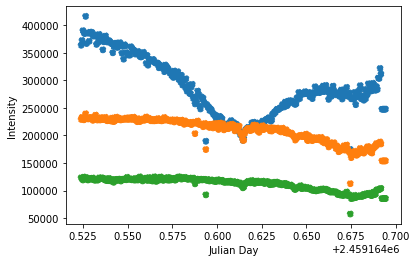

In [ ]:
#Plot of time-intensity for the 3 objects

star_list_nobkg = np.array(star_list_nobkg)
type(star_list_nobkg)

for star in range(star_list_nobkg.shape[1]):
  plt.scatter(time_list, star_list_nobkg[:, star], marker='o', linestyle='dashed')
plt.xlabel('Julian Day')
plt.ylabel('Intensity')
plt.savefig(f"{images_path}/aligned_with_FWHM_{FWHM_RESIZING_PARAMETER}.png")
plt.show()

In [ ]:
#Array of the main object with and without background

star_array = np.array(star_list.copy())
star_array_nobkg= np.array(star_list_nobkg.copy())

Text(0, 0.5, 'Intensity')

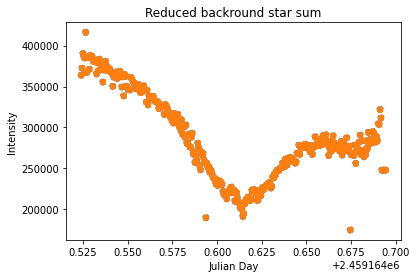

In [ ]:
#Plot of the main object with and without background

plt.scatter(time_list, star_array[:,0],marker='o', linestyle='dashed')
plt.scatter(time_list, star_array_nobkg[:,0],marker='o', linestyle='dashed')

plt.title('Reduced backround star sum')
plt.xlabel('Julian Day')
plt.ylabel('Intensity')

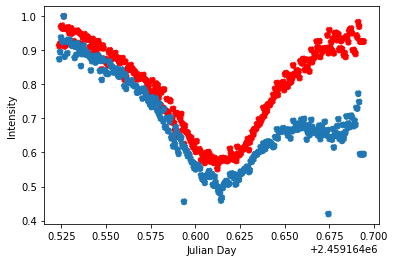

In [ ]:
#Normalization of the main object and one comparison object
#and plotting the comparison 

norm_var = star_list_nobkg[:, 0] / star_list_nobkg[:, 0].max()
norm_comp = star_list_nobkg[:, 1] / star_list_nobkg[:, 1].max()

plt.scatter(time_list, norm_var / norm_comp, marker='o', linestyle='dashed', color='red')
plt.scatter(time_list, norm_var, marker='o', linestyle='dashed')
plt.xlabel('Julian Day')
plt.ylabel('Intensity')
plt.show()

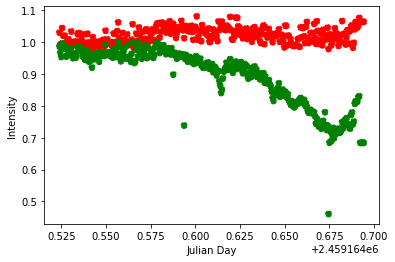

In [ ]:
#Normalization of the two comparison objects and plotting their comparison

norm_comp = star_list_nobkg[:, 1] / star_list_nobkg[:, 1].max()
norm_comp2 = star_list_nobkg[:, 2] / star_list_nobkg[:, 2].max()

plt.scatter(time_list, norm_comp2 / norm_comp, marker='o', linestyle='dashed', color='red')
plt.scatter(time_list, norm_comp2, marker='o', linestyle='dashed', color = 'green')
plt.xlabel('Julian Day')
plt.ylabel('Intensity')
plt.show()

In [ ]:
#CSV file that contains the flux values of the main and comparison objects
#NAME CSV FILES WITH DATE

with open('/content/drive/MyDrive/photometry_nobkg_v432per_10.csv', mode='w') as f:
  f.write('#time,star,comp_star1,comp_star2\n')
  for time, flux_values in zip(time_list, star_list_nobkg):
    # print(time, flux_values[0], flux_values[1])
    row = ','.join((str(time), str(flux_values[0]), str(flux_values[1]), str(flux_values[2]))) + '\n'
    f.write(row)